<center>
    <h1>Analyzing data and preprocessing</h1>
</center>

# 1. Setup

In [1]:
# Import base librairies
import sys
from pathlib import Path
from PIL import Image

# Import scientific librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Tensorflow
from tensorflow import keras

# Check running environment
try:
    import google.colab
    IN_COLAB=True
except:
    IN_COLAB=False

# Add project directory to kernel paths
if IN_COLAB:
    print("We're running on Colab")
    !git clone https://github.com/dailoht/Epitech_Zoidberg2.0.git
    sys.path.append('./Epitech_Zoidberg2.0')
else:
    print("We're running localy")
    sys.path.append('../..')

2023-03-27 16:41:56.545999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We're running localy


In [2]:
# Import custom functions
from src.visualization.plot_lib import default_viz
from src.data.file_manager import FileManager

zoidbergManager = FileManager()

# Set default graphics visualization
%matplotlib inline
default_viz()

# 2. Transform data into a common dataset

Before starting any analysis on the data, we just transform the data folder structure into a more convinient one:
- we remove train, val and set folder as we will split data later
- we provide 3 folders : one by class

This folder is in the interim data folder.

In [3]:
zoidbergManager.fetch_full_dataset()
print('')
is_ok = zoidbergManager.check_full_dataset(print_result=True)

Uncompressing zip file ...
Copying files from raw/Chest_Xray to interim/full ...

full dataset : class normal => nb images = 1583
full dataset : class bacteria => nb images = 2780
full dataset : class virus => nb images = 1493
----------------------------------------
raw data     : class bacteria => nb images = 2780
raw data     : class normal => nb images = 1583
raw data     : class virus => nb images = 1493


Then, we will create a DataFrame that contains metadata of each images in orders to analyse those images. Metadata we want to get are : 
 - Filename
 - Size of the image
 - Number of channels e.g. grayscale, rbg, rgba, so on
 - Label of the image  : normal, virus, bacteria

In [5]:
metadata = []
for img_path in Path(zoidbergManager.data_dir / "interim" / "full").rglob('*.jpeg'):
    with Image.open(img_path) as img:
        label = img_path.parents[0].name
        width, height = img.size
        channels = len(img.getbands())
        
        metadata.append((img_path.name, width, height, channels, label))

metadata_df = pd.DataFrame(metadata, columns=["image", "width", "height", "channels", "label"])

metadata_df.head()

,image,width,height,channels,label


# 3. Metadata analysis

Let's to get some insight by image metadata. We want to know image size and number of channels in order to resize them for CNN. We can also detect some outliers with those features. 

In [6]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     0 non-null      object
 1   width     0 non-null      object
 2   height    0 non-null      object
 3   channels  0 non-null      object
 4   label     0 non-null      object
dtypes: object(5)
memory usage: 0.0+ bytes


So, we have $5856$ images, for each of those, we were able to detect its size (*width* $\times$ *height*) and what kind of image it is (Grayscale, RGB, etc...). The numbers of images seems a bit short for deep learning, even if we will use **transfer learning**. We will probably need *data augmentation*.

### 3.1 Size & Channels

In [6]:
metadata_df.describe()

,width,height,channels
count,5856.000000,5856.000000,5856.000000
mean,1327.880806,970.689037,1.096653
std,363.500922,383.392117,0.428947
min,384.000000,127.000000,1.000000
25%,1056.000000,688.000000,1.000000
50%,1281.000000,888.000000,1.000000
75%,1560.000000,1187.000000,1.000000
max,2916.000000,2713.000000,3.000000


Clearly, the size of the images are widely distributed :
- width : from $384$ to $2916$ pixels
- height : from $127$ to $2713$ pixels

Most of images are grayscale (more than $75\%$) but some are also consiedered RGB. 


As their size distribution is not peaky, let's plot it in a violin plot :

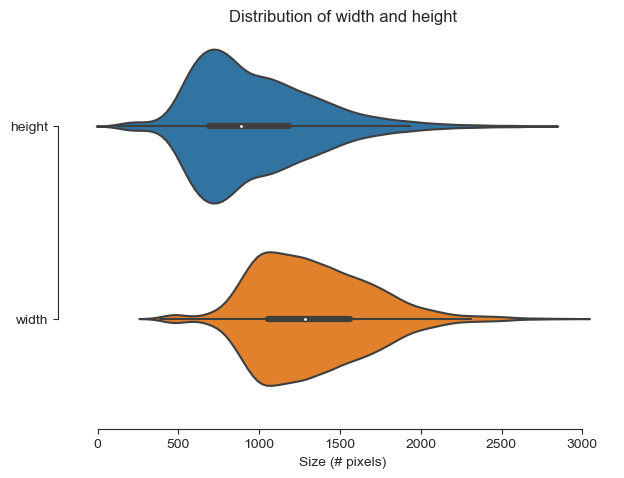

In [7]:
sns.set_style('ticks')
vp = sns.violinplot(data=metadata_df[['height','width']], orient='h')
vp.set_title("Distribution of width and height")
vp.set_xlabel("Size (# pixels)", fontsize=10)
sns.despine(offset=10, trim=True)


What we have plot is a violin plot : horizontal box corresponds to quantiles with the mean at the white dot. The colored space is the kernel density of a distribution.  
According to this violin plot, it appears that we will be able to resize images around $500\times 500$ without having to oversize too many images (oversizing can create blur in the image).


Let's now focus on channels and count how many images have a RGB channel : 

In [8]:
print(metadata_df['channels'].value_counts())

1    5573
3     283
Name: channels, dtype: int64


So, it turns out that $5\%$ of our dataset is considered to have a RGB, the rest have grayscale color. Let's try to display some of these images to see what they look like :

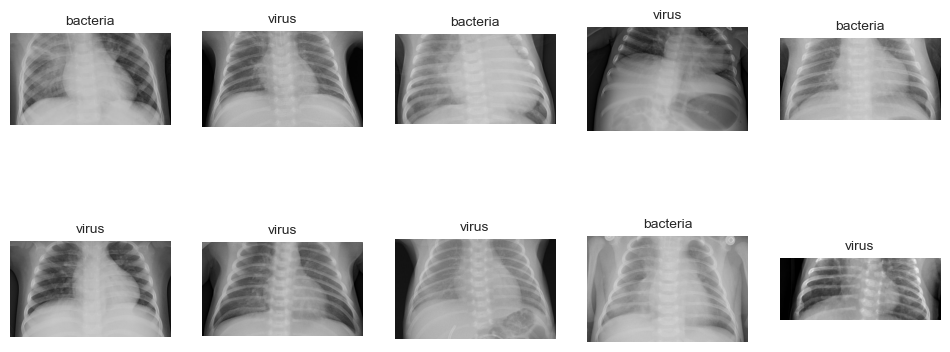

In [9]:
rgb_channel_df = metadata_df[metadata_df['channels'] == 3].sample(n=10, random_state=42)

fig, axes = plt.subplots(nrows=2, ncols=5,figsize=(12,5))
for i, ax in enumerate(axes.flat):
    if i < len(rgb_channel_df):
        image_name = rgb_channel_df['image'].iloc[i]
        image_dir = rgb_channel_df['label'].iloc[i]
        image_path = Path(zoidbergManager.data_dir / "interim" / "full" / image_dir / image_name)
        image = Image.open(image_path)
        ax.imshow(image)
        ax.set_title(image_dir,fontsize=10)
        ax.set_axis_off()
plt.show()

Everything is fine, it looks like that they were classified as RGB by the package `pyllow` but they are indeed black & white pictures. 

### 3.2 Labels

Finally, let's talk about labels. The most important thing we want to know is are there imbalanced classes (i.e if one class has much more data than the others). Class imbalance can make classification more challenging by biasing the model towards the majority class, leading to poor performance on the minority class, and misleading evaluation metrics.  
Thus, we display histogram for each class : 

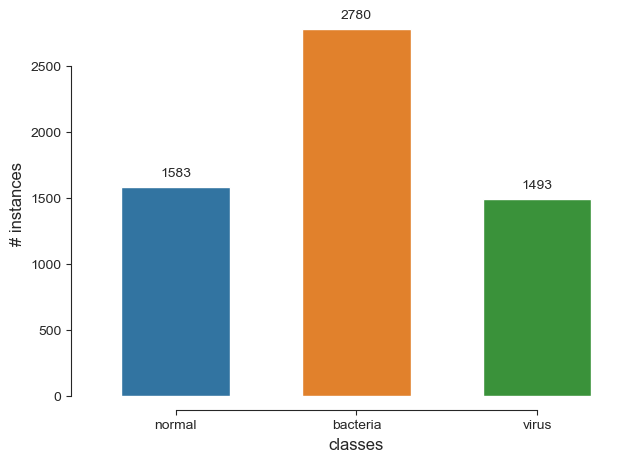

In [10]:
cp = sns.countplot(data = metadata_df, x='label', width=0.6)
cp.set_xlabel('classes')
cp.set_ylabel('# instances')
sns.despine(offset=10, trim=True)

for p in cp.patches:
    cp.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

**Bacteria class has widely twice times more records than normal and virus !**  
So, we need to handle class imbalance. We will do it by :
- do not choose accuracy as metrics but prefer $F_1$ - score
- set class weights inside our loss function.

# 4. TF dataset & train/test split